### PROPERTIES AND EXPLORATION OF HIDDEN *REPRESENTATIONS*


MAIN OBJECTIVES:
- extract hidden representation customising a standard model
- discuss qualitatively few basic techniques for analysis of *representations*

We set up the basics for training the models we are going to inspect later:

- we make sure folders in the course repo are available;
- we load the MNIST dataset and check the data looks as expected;
- we define basic training and test functionalities we will use for learning the weights of our model
- we define standard training hyperparameters

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
%cd /content/drive/MyDrive/PROVA

[Errno 2] No such file or directory: '/content/drive/MyDrive/PROVA'
/content


In [1]:
# basic imports, load MNIST
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')


minibatch_size_train = 64
minibatch_size_test = 1000

In [2]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = torchvision.datasets.MNIST('./data/', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size_train, shuffle=True)

testset = torchvision.datasets.MNIST('./data/', transform=transforms, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size_test, shuffle=False)


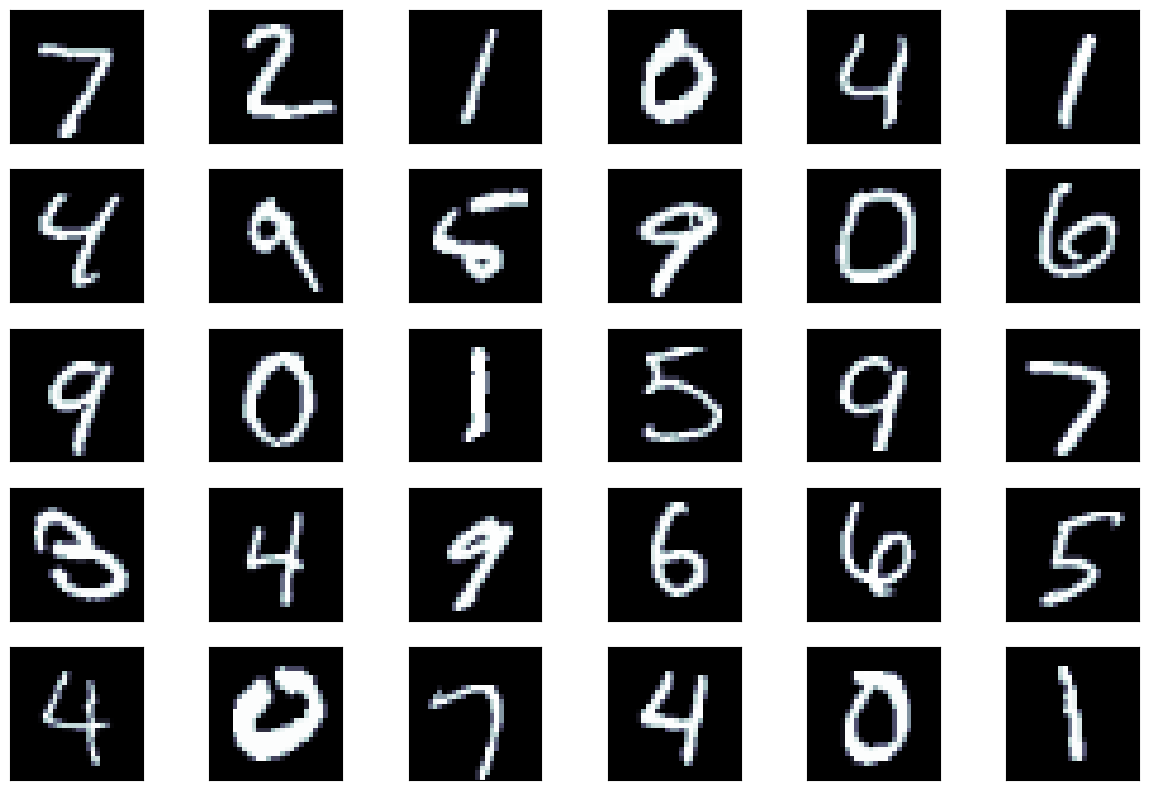

In [3]:
# a quick look at MNIST images
inputs,labels = next(iter(testloader))

fig=plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.xticks([])
    plt.yticks([])

In [4]:
#make sure we handle correctly hardware resources depending on availability, and fix seed
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
#fix basic training settings, and fix seed. NOTE: modify as you please!
seed = 33
torch.manual_seed(seed)
input_size=(1,28,28,)
epochs=5
lr=0.01
momentum=0.0
log_interval=100

In [6]:
#set up basic train and test functionalities
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
#define convolutional network with
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
model = ConvNet().to(device)
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [9]:
model.eval()
output = model(inputs.to(device))
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(labels.to(device).view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.084


In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
save=True

In [11]:
for epoch in range(1, epochs + 1):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

if save:
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326957
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.980501
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.819643
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.507352
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380954
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.506613
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.158702
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.235060
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.275482
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.197709

Test set: Average loss: 0.2058, Accuracy: 9316/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.181475
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.078584
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.141322
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.189052
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.124406
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.067173
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.242976
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.083223
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.059644
T

Exercise 1: Basics.
- Define a model ConvNetReps with an additional attribute to extract the hidden representations of the model ConvNet.
- Define an instance of ConvNetReps and load weights obtained from training of ConvNet
- Extract representations for a batch of the testloader, and inspect dimensions

In [12]:
from torchvision.datasets.mnist import read_sn3_pascalvincent_tensor
#define convolutional network with extract method
class ConvNetReps(nn.Module):
    def __init__(self):
        super(ConvNetReps, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def extract(self, x):
        r1 = F.relu(self.conv1(x))
        r2 = F.max_pool2d(r1, 2, 2)
        r3 = F.relu(self.conv2(r2))
        r4 = F.max_pool2d(r3, 2, 2)
        r4 = r4.view(-1, 4*4*50)
        r5 = F.relu(self.fc1(r4))
        r6 = self.fc2(r5)
        return r1, r2, r3, r4 ,r5, r6

In [13]:
#define instance of ConvNetReps(), load weights, set in evaluation mode
model = ConvNetReps()
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()

ConvNetReps(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
#load a batch of inputs from the testloader
#extract representations using method defined above
#inspect dimensions
x, y = next(iter(testloader))

In [15]:
x.shape, y.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [16]:
r1, r2, r3, r4, r5, r6 = model.extract(x)

In [17]:
r1.size(), r2.size(), r3.size(), r4.size(), r5.size(), r6.size()

(torch.Size([1000, 20, 24, 24]),
 torch.Size([1000, 20, 12, 12]),
 torch.Size([1000, 50, 8, 8]),
 torch.Size([1000, 800]),
 torch.Size([1000, 500]),
 torch.Size([1000, 10]))

Exercise 2: Visualisation.

Note that after each convolution each channel can be interpreted as an image.
- Choose an image and plot the first 20 channels for the first 4 layers. What does it show about the level of abstraction?

"T-distributed Stochastic Neighbor Embedding" [TSNE-sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) allows to project high dimensional data onto 2-d allowing simple visualisation that preserves some of the properties of the original data.
- Use TSNE to inspect the geometry of some layers (e.g. layers after second maxpooling, two last hidden layers).

- Take home message &/or reading exercise: TSNE has strenght and limitations [Distill-TSNE](https://distill.pub/2016/misread-tsne/)

Another popular tool for visualisation is "Uniform Manifold Approximation and Projection" [UMAP](https://umap-learn.readthedocs.io/en/latest/), and you can more read about the two here [TSNEvsUMAP](https://pair-code.github.io/understanding-umap/)

In [18]:
#tsne geometry inspection, NOTE: you will need to flatten the vectors first!!!
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, random_state=0)
'''
Your code here
NOTE: TSNE is a class that has a method fit_transform, so need use tsne.fit_transform
HINT: check examples in documentation
'''
# Choose a single image from the test batch
# (x has shape [batch, 1, 28, 28]); here we take only the first image.
img = x[0:1]  # shape becomes [1, 1, 28, 28]

# Obtain representations using the extract method of your model
r1, r2, r3, r4_flat, r5, r6 = model.extract(img)

# For r4, which was flattened, reshape it back to [batch, channels, height, width]
# Originally, after pooling, r4 had shape [1, 50, 4, 4]
r4 = r4_flat.view(-1, 50, 4, 4)

In [19]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

zsh:1: no matches found: umap-learn[plot]
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 4.8 MB/s eta 0:00:004.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 7.3 MB/s eta 0:00:007.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 9.9 MB/s eta 0:00:000m eta 0:00:010:00:01
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


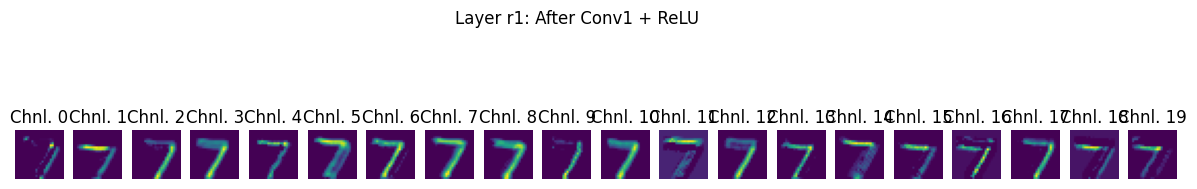

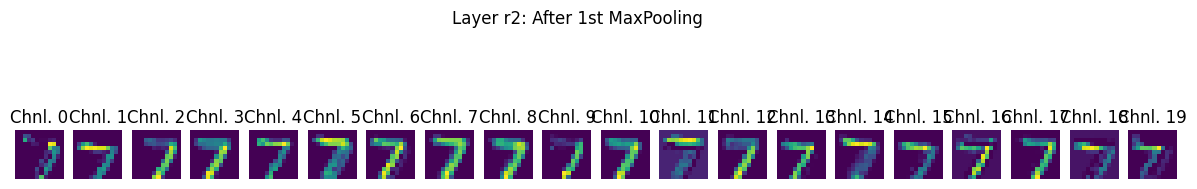

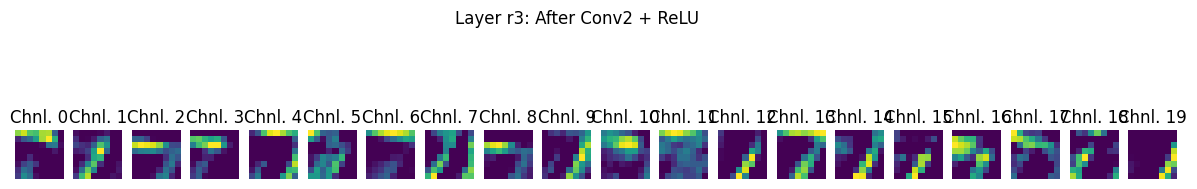

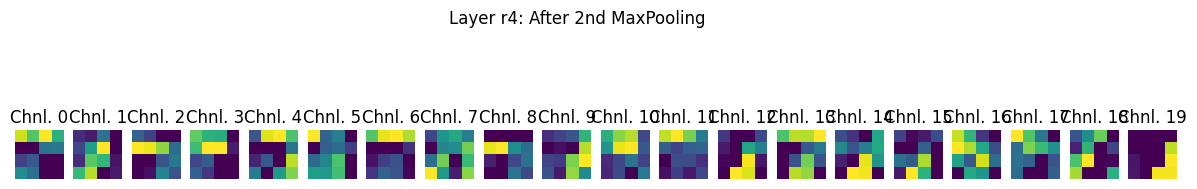

In [20]:
def plot_feature_maps(feature_maps, layer_name, num_channels=20):
    """
    Plot the first num_channels feature maps for a given layer.
    feature_maps: Tensor of shape [1, C, H, W]
    layer_name: Name of the layer (for title display)
    """
    # Extract the numpy array and squeeze the batch dimension
    fmap = feature_maps.detach().cpu().squeeze(0).numpy()  # now shape is [C, H, W]

    n_channels = fmap.shape[0]
    num_to_plot = min(num_channels, n_channels)

    plt.figure(figsize=(15, 3))
    for i in range(num_to_plot):
        plt.subplot(1, num_to_plot, i+1)
        plt.imshow(fmap[i], cmap='viridis')
        plt.title(f'Chnl. {i}')
        plt.axis('off')
    plt.suptitle(layer_name)
    plt.show()

# Plot for each desired layer:
plot_feature_maps(r1, "Layer r1: After Conv1 + ReLU")  # expected shape: [20, 24, 24]
plot_feature_maps(r2, "Layer r2: After 1st MaxPooling")   # expected shape: [20, 12, 12]
plot_feature_maps(r3, "Layer r3: After Conv2 + ReLU")     # expected shape: [50, 8, 8] -> plot first 20 channels
plot_feature_maps(r4, "Layer r4: After 2nd MaxPooling")    # expected shape: [50, 4, 4] -> plot first 20 channels

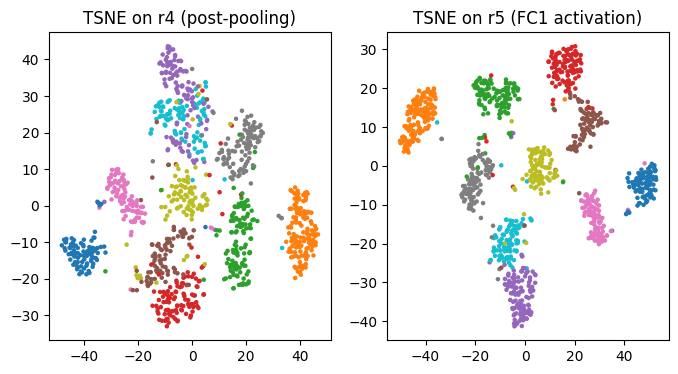

In [21]:
from sklearn.manifold import TSNE

# Pick a new batch from the test loader (use a larger batch for meaningful TSNE)
x_batch, y_batch = next(iter(testloader))  # x_batch shape: [1000, 1, 28, 28]

# Get the representations for the entire batch
r1_batch, r2_batch, r3_batch, r4_batch, r5_batch, r6_batch = model.extract(x_batch)
# r4_batch is flattened (shape [1000, 800]); r5_batch has shape [1000, 500]

# Initialize TSNE and compute the 2D embeddings
tsne = TSNE(n_components=2, random_state=0)
tsne_r4 = tsne.fit_transform(r4_batch.detach().cpu().numpy())
tsne_r5 = tsne.fit_transform(r5_batch.detach().cpu().numpy())

# Plot TSNE projections
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(tsne_r4[:, 0], tsne_r4[:, 1], c=y_batch, cmap='tab10', s=5)
plt.title("TSNE on r4 (post-pooling)")

plt.subplot(1, 2, 2)
plt.scatter(tsne_r5[:, 0], tsne_r5[:, 1], c=y_batch, cmap='tab10', s=5)
plt.title("TSNE on r5 (FC1 activation)")
plt.show()

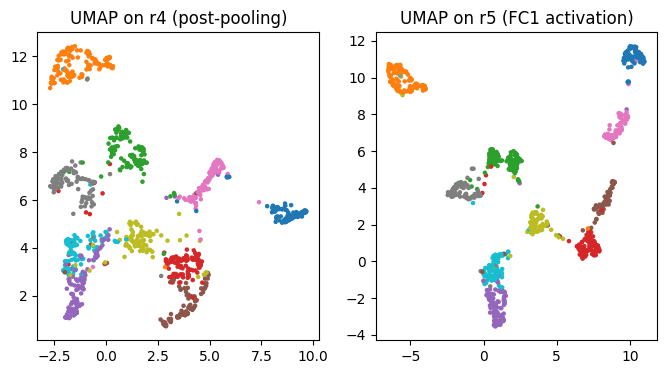

In [22]:
#umap geometry inspection
import umap

# Initialize UMAP reducer and compute embeddings for the same representations
umap_reducer = umap.UMAP(random_state=42)
umap_r4 = umap_reducer.fit_transform(r4_batch.detach().cpu().numpy())
umap_r5 = umap_reducer.fit_transform(r5_batch.detach().cpu().numpy())

# Plot UMAP projections
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(umap_r4[:, 0], umap_r4[:, 1], c=y_batch, cmap='tab10', s=5)
plt.title("UMAP on r4 (post-pooling)")

plt.subplot(1, 2, 2)
plt.scatter(umap_r5[:, 0], umap_r5[:, 1], c=y_batch, cmap='tab10', s=5)
plt.title("UMAP on r5 (FC1 activation)")
plt.show()

Exercise 3: Intrinsic dimension

Monitoring the dimension of the representations of a dataset in the hidden layers of a DNN can reveal information about the learning procedure (see for instance [Ansuini et al., 2019](https://proceedings.neurips.cc/paper/2019/file/cfcce0621b49c983991ead4c3d4d3b6b-Paper.pdf) ).

We consider the TWO-NN algorithm for estimating the intrinsic dimension [Facco et al., 2018](https://www.nature.com/articles/s41598-017-11873-y.pdf) of the representations in various hidden layers. The algorithm only uses the distance among the datapoints.

- The ID estimation is as more reliable as more points we consider. Modify the definition of test loader to obtain batches of 5000. Extract representations.
- Start by the input representation of this batch: compute the distance matrix using SciPy [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) and [squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html) functions.
- Use the function block_analysis as indicated to compute the decimation curve of ID and the corresponding errors. Plot the results (with error bars).
- Do the same for other hidden representations (I suggest 3,6,7 -why?-). Plot the curves together and discuss the behaviour of the ID in the hidden representations of the model.

In [23]:
# Step 1: Modify the test loader to have a batch size of 5000.
# (Reinitialize a test loader for a larger batch.)
testset_large = torchvision.datasets.MNIST('./data/', transform=transforms, train=False, download=True)
testloader_large = torch.utils.data.DataLoader(testset_large, batch_size=5000, shuffle=False)

# Get one large batch from the test set
x_large, y_large = next(iter(testloader_large))

In [24]:
# Step 2: Extract representations.
# Run the model's extract method on the large batch.
# Our extract method returns 6 items: (r1, r2, r3, r4, r5, r6)
# We'll use:
#   - Input: x_large (flattened to 784)
#   - Layer 3: r2 (after first max pooling)
#   - Layer 6: r5 (first fully-connected layer)
#   - Layer 7: r6 (final output; note that in our forward() we apply log_softmax)
x_large_flat = x_large.view(x_large.size(0), -1)  # shape: [5000, 784]

# Make sure the model is in evaluation mode.
model.eval()
with torch.no_grad():
    r1, r2, r3, r4, r5, r6 = model.extract(x_large)

# For layer 3 (as suggested), use r2.
X_layer3 = r2.view(r2.size(0), -1)  # flatten; original shape [5000, 20, 12, 12] becomes [5000, 2880]

# For layer 6, use r5 (already [5000, 500])
X_layer6 = r5

# For layer 7, use r6 (already [5000, 10])
X_layer7 = r6

In [25]:
# Step 3: Compute the distance matrices.
from scipy.spatial.distance import pdist, squareform

# Compute distance matrix for each representation.
# (Convert tensors to NumPy arrays.)
d_input   = squareform(pdist(x_large_flat.detach().cpu().numpy()))
d_layer3  = squareform(pdist(X_layer3.detach().cpu().numpy()))
d_layer6  = squareform(pdist(X_layer6.detach().cpu().numpy()))
d_layer7  = squareform(pdist(X_layer7.detach().cpu().numpy()))

In [26]:
# Step 4: Estimate intrinsic dimension using block_analysis.
# Import functions for ID estimation.
from intrinsic_dimension import estimate,block_analysis

# For each distance matrix, compute the decimation curve:
id_input   = block_analysis(d_input)    # id_input[0]: ID estimates along curve,
                                         # id_input[1]: error estimates,
                                         # id_input[2]: number of points considered.

id_layer3  = block_analysis(d_layer3)
id_layer6  = block_analysis(d_layer6)
id_layer7  = block_analysis(d_layer7)

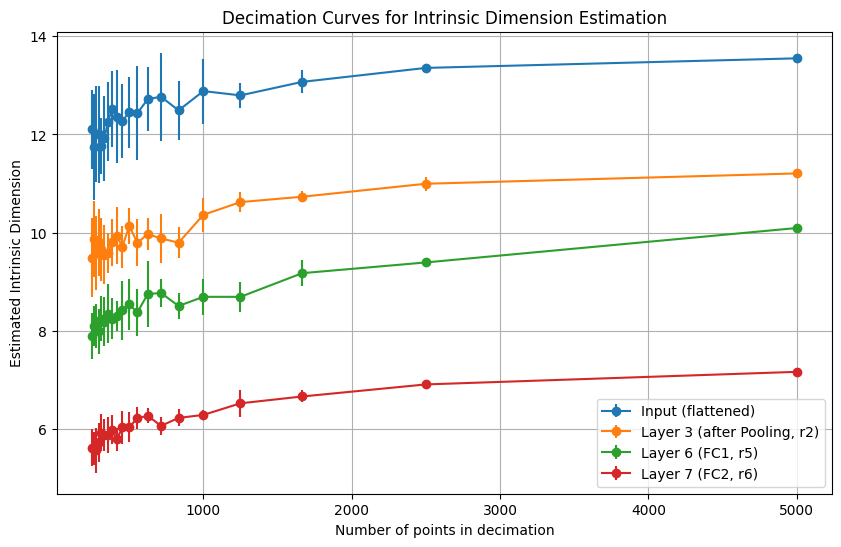

In [27]:
# Step 5: Plot the decimation curves with error bars.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot for the input representation.
plt.errorbar(id_input[2], id_input[0], yerr=id_input[1], fmt='-o', label='Input (flattened)')

# Plot for the representation from layer 3 (r2: after 1st pooling)
plt.errorbar(id_layer3[2], id_layer3[0], yerr=id_layer3[1], fmt='-o', label='Layer 3 (after Pooling, r2)')

# Plot for layer 6 (first fully-connected layer, r5)
plt.errorbar(id_layer6[2], id_layer6[0], yerr=id_layer6[1], fmt='-o', label='Layer 6 (FC1, r5)')

# Plot for layer 7 (final layer, r6)
plt.errorbar(id_layer7[2], id_layer7[0], yerr=id_layer7[1], fmt='-o', label='Layer 7 (FC2, r6)')

plt.xlabel('Number of points in decimation')
plt.ylabel('Estimated Intrinsic Dimension')
plt.title('Decimation Curves for Intrinsic Dimension Estimation')
plt.legend()
plt.grid(True)
plt.show()

Exercise 4: Neihgborhood overlap

Monitoring the geometry of the representations of a dataset in the hidden layers of a DNN can reveal information about the learning procedure (see for instance [Doimo et al., 2020](https://arxiv.org/abs/2007.03506) ).

We consider the Neighborhood Overlap algorithm to compare representations, and to monitor emergence of semantic meaning in various hidden layers. The algorithm only uses the nearest neighbor matrix for some chosen hyperparameter $k$.

Exercise 4.1, compare representations:
- define a function that computes the neighborhood overlap of two representations of the same dataset ($\chi^{l,m}$);
- compute neighborhood overlap for representations extracted in Exercise 1 for the MNIST dataset;
- comment on results.

NOTE: in the function below it is suggested that you start from the matrix of k-NN indices. This is not mandatory, you can implement a version that starts simply from coordinates of points in the two representations.

In [28]:
def compute_knn_indices(X, k=10):
    """
    Computes the k-nearest neighbors indices of a dataset X.

    Parameters
    ----------
    X : 2D numpy array of floats, shape (ndata, dim)
        Data points in some representation.
    k : int
        Number of neighbors to return (excluding self). Actually, k+1 neighbors are computed,
        with the first neighbor being the point itself.

    Returns
    -------
    indices : 2D numpy array of ints, shape (ndata, k+1)
        Nearest neighbor indices for each point.
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    return indices

In [29]:
from sklearn.neighbors import NearestNeighbors
# ----------------------------------------------------------------------------
# 2. Neighborhood Overlap Function
# ----------------------------------------------------------------------------
def neig_overlap(X, Y, K=10):
    """
    Computes the neighborhood overlap between two representations.

    Parameters
    ----------
    X : 2D array of ints
        Nearest neighbor index matrix of the first representation (shape: [ndata, K]).
    Y : 2D array of ints
        Nearest neighbor index matrix of the second representation (shape: [ndata, K]).
    K : int
        Number of nearest neighbors used.

    Returns
    -------
    overlap : float
        The average fraction of overlap between the two k-NN lists.
    """
    # Ensure that both matrices have the same number of datapoints.
    assert X.shape[0] == Y.shape[0], "The two representations must cover the same number of points."
    ndata = X.shape[0]
    overlaps = np.empty(ndata)
    for i in range(ndata):
        # Convert the i-th neighbor lists to sets.
        neighbors_X = set(X[i])
        neighbors_Y = set(Y[i])
        # Overlap for point i is the number of shared neighbors divided by K.
        overlaps[i] = len(neighbors_X.intersection(neighbors_Y)) / K
    return np.mean(overlaps)

In [30]:
# Assume x_batch and the corresponding extraction have been computed:
# For example:
#   r1, r2, r3, r4, r5, r6 = model.extract(x_batch)
# where:
#   - r2 is the output after first max pooling (say layer 3),
#   - r5 is the output after the first fully-connected layer (layer 6).

x_batch, y_batch = next(iter(testloader))
model.eval()
with torch.no_grad():
    r1, r2, r3, r4_flat, r5, r6 = model.extract(x_batch)

# We will compare r2 and r5:
# Flatten r2 so that each example is a vector.
X_r2 = r2.view(r2.size(0), -1).cpu().numpy()   # e.g. shape (1000, 20*12*12)
X_r5 = r5.cpu().numpy()                         # shape (1000, 500)

# Compute the kNN indices (using k=10 neighbors, so matrices will have shape (ndata, 11))
indices_r2 = compute_knn_indices(X_r2, k=10)
indices_r5 = compute_knn_indices(X_r5, k=10)

# Compute neighborhood overlap between these representations.
overlap_r2_r5 = neig_overlap(indices_r2, indices_r5, K=10)
print("Neighborhood Overlap between layer 3 (r2) and layer 6 (r5):", overlap_r2_r5)

Neighborhood Overlap between layer 3 (r2) and layer 6 (r5): 0.7353999999999999


### **Comment on the results**
A higher overlap value (close to 1) would indicate that many of the nearest neighbors in one representation are also neighbors in the other.

Exercise 4.2, emergence of semantic:
- define a function that computes the overlap of a representation with given labels ($\chi^{l,\textrm{gt}}$);
- compute alignment with labels for representations extracted in Exercise 1 for the MNIST dataset;
- comment on the results.

NOTE: in the function below it is suggested that you start from the matrix of k-NN indices. This is not mandatory, you can implement a version that starts simply from coordinates of points in the two representations.

In [31]:
def compute_label_overlap(indices, labels, k=10):
    """
    Computes the neighborhood overlap with the ground truth labels.

    Parameters
    ----------
    indices : 2D numpy array of ints, shape (ndata, k+1)
        Nearest neighbor index matrix of the representation (first column should be self).
    labels : 1D numpy array of ints, shape (ndata,)
        Ground truth labels for each data point.
    k : int, optional (default=10)
        Number of nearest neighbors (excluding self) used to compute the overlap.

    Returns
    -------
    overlap : float
        Average fraction of the k nearest neighbors that have the same label as the point.
    """
    # Skip the first column (assumed to be the point itself).
    neighbor_indices = indices[:, 1:k+1]
    ndata = indices.shape[0]
    overlaps = np.empty(ndata)

    for i in range(ndata):
        # Get the labels of the neighbors.
        neighbor_labels = labels[neighbor_indices[i]]
        # Compute fraction of neighbors that have the same label as the current point.
        overlaps[i] = np.mean(neighbor_labels == labels[i])
    return np.mean(overlaps)

In [32]:
# For example, compute label overlap for the representation r5 (layer 6).

# We already have X_r5 from before, and y_batch is a tensor of labels.
X_r5 = r5.cpu().numpy()
labels_np = y_batch.cpu().numpy()

# Compute the kNN indices for r5 (using k+1=11 neighbors).
indices_r5 = compute_knn_indices(X_r5, k=10)

# Compute the neighborhood label overlap.
label_overlap_r5 = compute_label_overlap(indices_r5, labels_np, k=10)
print("Label Neighborhood Overlap for layer 6 (r5):", label_overlap_r5)

Label Neighborhood Overlap for layer 6 (r5): 0.9181


Extra Exercises:

- Repeat the analysis for the hidden representations of MNIST obtained through your favourite MLP classifier. Compare qualitative the results to the one obtained with CNN.

- Implement neighborhood overlap method and apply it to representations extracted from various layers of our models.